In [22]:
%matplotlib inline

Working with data
-----------------
PyTorch has two primitives to work with data:<br>
torch.utils.data.DataLoader: wraps an iterable around the Dataset<br>
torch.utils.data.Dataset: stores the samples and their corresponding labels

PyTorch offers domain-specific libraries such as TorchText, TorchVision, and TorchAudio,
that provide a number of pre-loaded datasets:<br>
Image Datasets: pytorch.org/vision/stable/datasets,<br>
Text Datasets: pytorch.org/text/stable/datasets,<br>
Audio Datasets: pytorch.org/audio/stable/datasets<br>

they subclass torch.utils.data.Dataset and implement functions specific to the particular data

torchvision.datasets module<br>
-contains Dataset objects for many real-world vision data like FashionMNIST, CIFAR, COCO, etc.<br>

In [9]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets

In [10]:
from torch import nn
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

#### Transforms
- are used to perform some manipulation of the data and make it suitable for training
- all TorchVision datasets have two parameters<br>
transform: to modify the samples,<br>
target_transform: to modify the labels
- the `torchvision.transforms` module offers several commonly-used transforms out of the box

The FashionMNIST features are in PIL Image format, and the labels are integers.
For training, we need the features as normalized tensors, and the labels as one-hot encoded tensors.

ToTensor(): converts a PIL image or NumPy ``ndarray`` into a ``FloatTensor`` and scales
the image's pixel intensity values in the range [0., 1.]

user-defined lambda function:<br>
- here, we define a function to turn the integer into a one-hot encoded tensor
- it first creates a zero tensor of size 10 (the number of labels in our dataset) and calls
scatter_ which assigns a ``value=1`` on the index as given by the label ``y``

In [24]:
#one-hot
#target_transform = Lambda(lambda y: torch.zeros(
#    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [11]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor(),)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor(),)

We pass the Dataset as an argument to DataLoader - this wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading.<br>

#### Iterating the Dataset

iteration/indexing: a list training_data[index]

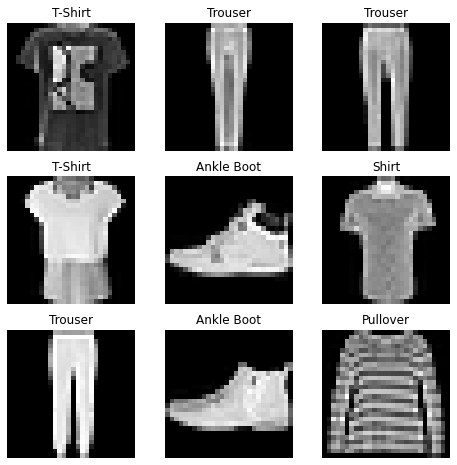

In [12]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Creating a Custom Dataset for your files
---------------------------------------------------
A custom Dataset class must implement three functions:.<br>
``__init__``: is run once when instantiating the Dataset object. We initialize
the directory containing the images, the annotations file, and both transforms.

``__len__``: returns the number of samples in our dataset

``__getitem__``: loads and returns a sample from the dataset at the given index ``idx``.<br>
Based on the index, it identifies the image's location on disk, converts that to a tensor using ``read_image``, retrieves the corresponding label from the csv data in ``self.img_labels``, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

Here: the FashionMNIST images are stored in a directory ``img_dir``, and their labels are stored separately in a CSV file ``annotations_file``.

In [13]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Preparing your data for training with DataLoaders
-------------------------------------------------
The ``Dataset`` retrieves our dataset's features and labels one sample at a time.<br>
While training a model, we typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's ``multiprocessing`` to speed up data retrieval.

``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Iterate through the DataLoader
--------------------------

We have loaded that dataset into the ``DataLoader`` and can iterate through the dataset as needed.
Each iteration below returns a batch of ``train_features`` and ``train_labels`` (containing ``batch_size=64`` features and labels respectively).
Because we specified ``shuffle=True``, after we iterate over all batches the data is shuffled (for finer-grained control over
the data loading order, take a look at `Samplers <https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler>`_).



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


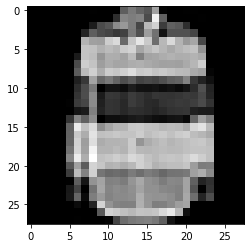

Label: 6


In [15]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Hyperparameters
-----------------

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates.

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

In [26]:
#learning_rate = 1e-3
#batch_size = 64
#epochs = 5

In [16]:
batch_size = 64
# Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

print(X.size())

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64
torch.Size([64, 1, 28, 28])


Creating Models
------------------
To define a neural network in PyTorch, we create a class that inherits from nn.Module.<br>
We define the layers of the network in the ``__init__`` function.<br>
We specify how data will pass through the network in the forward function.<br>
To accelerate operations in the neural network, we move it to the GPU if available.

In [17]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

#nn.Sequential is an ordered container of modules
#The data is passed through all the modules in the same order as defined
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),      #is applied after linear transformations to introduce nonlinearity
            nn.Linear(512, 10)
        )
#The last linear layer of the neural network returns `logits` - raw values in [-\infty, \infty]
#when they are passed to the `nn.Softmax` module, they got scaled to values [0, 1]
#representing the model's predicted probabilities for each class.
#dim parameter indicates the dimension along which the values must sum to 1.


#Do not call model.forward() directly!
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


#we create an instance of NeuralNetwork, and move it to the device, and print its structure
model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


#### Layers

In [36]:
#input_image = torch.rand(3,28,28)
#print(input_image.size())

#flatten = nn.Flatten()
#flat_image = flatten(input_image)
#print(flat_image.size())

#layer1 = nn.Linear(in_features=28*28, out_features=20)
#hidden1 = layer1(flat_image)
#print(hidden1.size())

#print(f"Before ReLU: {hidden1}\n\n")
#hidden1 = nn.ReLU()(hidden1)
#print(f"After ReLU: {hidden1}")

#seq_modules = nn.Sequential(
#    flatten,
#    layer1,
#    nn.ReLU(),
#    nn.Linear(20, 10)
#)
#input_image = torch.rand(3,28,28)
#logits = seq_modules(input_image)

#softmax = nn.Softmax(dim=1)
#pred_probab = softmax(logits)

torch.Size([3, 28, 28])
torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU: tensor([[ 0.4744, -0.0531, -0.0910,  0.4040, -0.2918,  0.0881, -0.6167, -0.2391,
         -0.1788,  0.1536, -0.0908, -0.2957,  0.0868, -0.1355,  0.1971, -0.1443,
          0.0940,  0.1610,  0.2328,  0.4784],
        [ 0.8194,  0.2368,  0.2059,  0.0772, -0.2923,  0.0086, -0.8330, -0.3690,
         -0.0980, -0.2269, -0.0968, -0.6648, -0.3732, -0.0360, -0.6289, -0.3586,
          0.2295,  0.1855,  0.5291,  0.6245],
        [ 0.5809, -0.0479,  0.0466,  0.2181,  0.0204,  0.3441, -0.4724,  0.0562,
         -0.1250,  0.2688, -0.0380, -0.5037,  0.2623, -0.3303, -0.3001, -0.2192,
          0.1725, -0.0605,  0.5609,  0.6825]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4744, 0.0000, 0.0000, 0.4040, 0.0000, 0.0881, 0.0000, 0.0000, 0.0000,
         0.1536, 0.0000, 0.0000, 0.0868, 0.0000, 0.1971, 0.0000, 0.0940, 0.1610,
         0.2328, 0.4784],
        [0.8194, 0.2368, 0.2059, 0.0772, 0.0000, 0.0086, 0.0000, 0.00

Optimizing the Model Parameters
----------------------------------------
To train a model, we need a loss function and an optimizer and pass it to train loop and test loop.

#### Loss Function
- measures the degree of dissimilarity of obtained result to the target value
- is minimized during training
- to calculate the loss we make a prediction using the inputs of our given data sample and compare it against the true data label value

Common loss functions include `nn.MSELoss` (Mean Square Error) for regression tasks, and
`nn.NLLLoss`(Negative Log Likelihood) for classification.
`nn.CrossEntropyLoss` combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.

In [21]:
loss_fn = nn.CrossEntropyLoss()

#### Optimizer

- Optimization: the process of adjusting model parameters to reduce model error in each training step.
- Optimization algorithms define how this process is performed: SGD, ADAM, RMSProp
- All optimization logic is encapsulated in the optimizer object.
- We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.

In [22]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Training a model is an iterative process; in each iteration (called an *epoch*) the model makes a guess about the output, calculates the error in its guess (*loss*), collects the derivatives of the error with respect to its parameters, and **optimizes** these parameters using gradient descent.

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

In [23]:
#we define train method that loops over our optimization code

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

# Backpropagation---

#Inside the training loop, optimization happens in three steps:

#-Call optimizer.zero_grad() to reset the gradients of model parameters. 
# Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        optimizer.zero_grad()

#Backpropagate the prediction loss with a call to loss.backwards().
#PyTorch deposits the gradients of the loss w.r.t. each parameter.
        loss.backward()

#Once we have our gradients, we call optimizer.step() to adjust the parameters
#by the gradients collected in the backward pass.
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [24]:
#we define test_loop that evaluates the model's performance against our test data

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations *epochs*.<br>
During each epoch, the model learns parameters to make better predictions.<br>
We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.

In [25]:
#To use the model, we pass it the input data.
#This executes the model's forward, along with some background operations.

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304628  [    0/60000]
loss: 2.294384  [ 6400/60000]
loss: 2.265129  [12800/60000]
loss: 2.260792  [19200/60000]
loss: 2.263097  [25600/60000]
loss: 2.219875  [32000/60000]
loss: 2.238781  [38400/60000]
loss: 2.202724  [44800/60000]
loss: 2.198529  [51200/60000]
loss: 2.168016  [57600/60000]
Test Error: 
 Accuracy: 33.3%, Avg loss: 2.160757 

Epoch 2
-------------------------------
loss: 2.172502  [    0/60000]
loss: 2.163223  [ 6400/60000]
loss: 2.103494  [12800/60000]
loss: 2.121705  [19200/60000]
loss: 2.090804  [25600/60000]
loss: 2.016382  [32000/60000]
loss: 2.054311  [38400/60000]
loss: 1.977199  [44800/60000]
loss: 1.988357  [51200/60000]
loss: 1.919157  [57600/60000]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.912246 

Epoch 3
-------------------------------
loss: 1.945292  [    0/60000]
loss: 1.915265  [ 6400/60000]
loss: 1.804762  [12800/60000]
loss: 1.844501  [19200/60000]
loss: 1.749438  [25600/60000]
loss: 1.689220  [32000/600

#### Model Parameters

Many layers inside a neural network are *parameterized*, i.e. have associated weights
and biases that are optimized during training. Subclassing ``nn.Module`` automatically
tracks all fields defined inside your model object, and makes all parameters
accessible using your model's ``parameters()`` or ``named_parameters()`` methods.

In [26]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure:  NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
) 


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0088,  0.0262,  0.0222,  ...,  0.0094, -0.0259,  0.0302],
        [ 0.0038,  0.0280, -0.0059,  ..., -0.0048, -0.0105,  0.0110]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([0.0288, 0.0117], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0031, -0.0355,  0.0138,  ...,  0.0163, -0.0347, -0.0028],
        [-0.0231,  0.0393, -0.0342,  ...,  0.0415, -0.0366, -0.0185]],
       device='cuda:0', grad_fn=<Sl

Saving Models Weights
-------------
save a model (the learned parameters) = serialize the internal state dictionary ``state_dict`` (containing the model parameters)<br>
method: ``torch.save``

In [27]:
# model = models.vgg16(pretrained=True) #jakiś pretrenowany model 

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models Weights
----------------------------
To load model weights, you need to create an instance of the same model first, and then load the parameters using ``load_state_dict()`` method.

In [28]:
model = NeuralNetwork()  # do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



In [23]:
#We might want to save the structure of this class together with the model, 
#in which case we can pass model (and not model.state_dict()) to the saving function:
torch.save(model, 'model.pth')

#We can then load the model like this:
model = torch.load('model.pth')

#This approach uses Python pickle module when serializing the model, 
#thus it relies on the actual class definition to be available when loading the model.

In [31]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

Be sure to call ``model.eval()`` method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.

In [32]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [34]:
#X = torch.rand(1, 28, 28, device=device)
#logits = model(X)
#pred_probab = nn.Softmax(dim=1)(logits)
#y_pred = pred_probab.argmax(1)
#print(f"Predicted class: {y_pred}")

In [33]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Further Reading
-----------------------
- `Saving and Loading a General Checkpoint in PyTorch <https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html>`_
- `Loss Functions <https://pytorch.org/docs/stable/nn.html#loss-functions>`_
- `torch.optim <https://pytorch.org/docs/stable/optim.html>`_
- `Warmstart Training a Model <https://pytorch.org/tutorials/recipes/recipes/warmstarting_model_using_parameters_from_a_different_model.html>`